In [1]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras import regularizers
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LeakyReLU, ReLU
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score, confusion_matrix
from tensorflow.keras.optimizers import Adam, RMSprop
import keras_tuner as kt

## Loading the Dataset

In [2]:
#looking at the preprocessed data
df = pd.read_csv("cleaned_dataset.csv")
df.head(10)

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,active,cardio
0,-0.433834,2,0.443711,-0.845741,-0.921194,-0.134931,1,1,0,1,0
1,0.309613,1,-1.018961,0.759448,0.771644,0.877460,3,1,0,1,1
2,-0.245845,1,0.078043,-0.706160,0.207365,-1.147322,3,1,0,0,1
3,-0.745799,2,0.565600,0.550076,1.335923,1.889851,1,1,0,1,1
4,-0.806166,1,-1.018961,-1.264486,-1.485474,-2.159713,1,1,0,0,0
5,0.992694,1,-1.628408,-0.496787,-0.356915,-0.134931,2,2,0,0,0
6,1.073318,1,-0.897072,1.317775,0.207365,-0.134931,3,1,0,1,0
7,1.264143,2,1.662604,1.457357,0.207365,0.877460,3,3,0,1,1
8,-0.727567,1,-0.775183,-0.217624,-0.921194,-1.147322,1,1,0,1,0
9,0.149985,1,-0.043847,-0.426996,-0.921194,-2.159713,1,1,0,0,0


## Splitting the dataset into trainning and test

In [3]:
X = df.drop(["cardio"],axis=1)
y = df["cardio"].astype(int)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3)

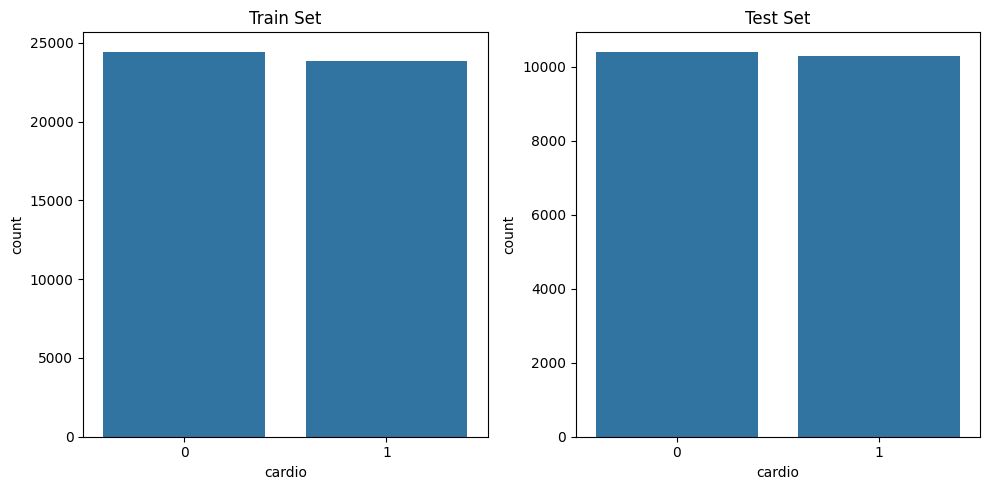

In [4]:
#looking at the counts for training and test dataset
fig, ax = plt.subplots(1,2,figsize = (10,5))
sns.countplot(data=df, x = y_train, ax = ax[0])
ax[0].set_title("Train Set")
sns.countplot(data=df, x = y_test, ax = ax[1])
ax[1].set_title("Test Set")
plt.tight_layout()

## Choosing the best neural network architecture

First, let us find the neural network architecture for training.

### Network with one hidden layer

In [5]:
def build_model(hp):
    model = Sequential()
    
    # Input Layer with fixed unit choices
    model.add(Dense(hp.Choice('units', [128, 256, 512, 1024])))

    # Activation function selection
    activation_choice = hp.Choice('activation', ['relu', 'leaky_relu'])
    if activation_choice == 'relu':
        model.add(ReLU())
    else:
        model.add(LeakyReLU(negative_slope=0.01))  # Default Leaky ReLU alpha=0.01

    # Dropout Layer with tunable choice
    model.add(Dropout(hp.Choice('dropout', values=[0.1, 0.2, 0.3])))  

    # Output layer (Binary classification)
    model.add(Dense(1, activation='sigmoid'))

    # Optimizer selection
    optimizer_choice = hp.Choice('optimizer', ['adam', 'rmsprop'])
    learning_rate = hp.Choice('learning_rate', values=[0.05, 0.01, 0.001])  # Added another value for tuning

    if optimizer_choice == 'adam':
        optimizer = Adam(learning_rate=learning_rate)
    else:
        optimizer = RMSprop(learning_rate=learning_rate)

    # Compile the model
    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=[tf.keras.metrics.Recall(),tf.keras.metrics.Precision()]
    )
    return model

In [6]:
# Initialize Keras Tuner with Hyperband, lowering max_epochs to 20 and factor to 3
tuner = kt.Hyperband(
    build_model,
    objective=['val_recall','val_precision'],  # Optimize for recall
    max_epochs=15,           # Reduced maximum epochs
    factor=4,
    directory='One hidden layer',
    project_name='disease_classification_fast')

In [7]:
# # Define Early Stopping callback
# early_stopping = EarlyStopping(
#     monitor='val_recall',  # Stop training if recall doesn't improve
#     patience=4,            # Wait for 4 epochs before stopping
#     restore_best_weights=True  # Restore best model
# )

# Perform hyperparameter search
tuner.search(
    X_train, y_train, 
    epochs=15,  
    validation_data=(X_test, y_test),
    batch_size=64,
    #callbacks=[early_stopping],  # Use Early Stopping
    verbose=1
)

Trial 11 Complete [00h 00m 32s]
multi_objective: -1.4779848456382751

Best multi_objective So Far: -1.4980929493904114
Total elapsed time: 00h 02m 58s


In [8]:
# Retrieve the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
Best number of units in the first layer: {best_hps.get('units')}
Best activation function: {best_hps.get('activation')}
Best dropout rate: {best_hps.get('dropout')}
Best optimizer: {best_hps.get('optimizer')}
Best learning rate: {best_hps.get('learning_rate')}
""")


Best number of units in the first layer: 256
Best activation function: leaky_relu
Best dropout rate: 0.3
Best optimizer: adam
Best learning rate: 0.05



In [9]:
# Build and train the best model using the best batch size from hyperparameters with verbose off
best_model = tuner.hypermodel.build(best_hps)
history = best_model.fit(X_train, y_train, epochs=20, validation_data=(X_test, y_test), 
                         batch_size=32,
                         verbose=1)

# Evaluate on the test set with verbose off
loss, recall, precision = best_model.evaluate(X_test, y_test, verbose=0)
print(f"Test Recall: {recall:.4f}")
print(f"Test Precision: {precision:.4f}")

Epoch 1/20
1510/1510 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.6286 - precision_3: 0.6946 - recall_3: 0.6507 - val_loss: 0.5955 - val_precision_3: 0.7383 - val_recall_3: 0.6712
Epoch 2/20
1510/1510 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.6267 - precision_3: 0.6962 - recall_3: 0.6410 - val_loss: 0.6141 - val_precision_3: 0.7042 - val_recall_3: 0.7464
Epoch 3/20
1510/1510 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.6223 - precision_3: 0.6973 - recall_3: 0.6465 - val_loss: 0.5792 - val_precision_3: 0.6975 - val_recall_3: 0.7535
Epoch 4/20
1510/1510 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.6315 - precision_3: 0.6928 - recall_3: 0.6464 - val_loss: 0.5705 - val_precision_3: 0.7583 - val_recall_3: 0.6491
Epoch 5/20
1510/1510 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.6306 - precision_3: 0.6939 - recall_3: 0.6398 - val_loss: 0.5879 - val_precision_3: 0.7491 - val_recall_3: 0.6363
Epoch 6/20
1510/1510 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.6374 - precision_3: 0.6895 - recall_3: 0.6479 

In [10]:
y_pred = best_model.predict(X_test,verbose=0)
y_pred_classes = (y_pred>=0.5).astype(int)

In [11]:
con_matrix = confusion_matrix(y_test, y_pred_classes)
con_matrix = pd.DataFrame(data = con_matrix, columns= ["Predicted 0","Predicted 1"], index= ["Actual 0", "Actual 1"])
con_matrix

,Predicted 0,Predicted 1
Actual 0,3378,7035
Actual 1,719,9568


In [12]:
accuracy = accuracy_score(y_test, y_pred_classes) *100
precision = precision_score(y_test, y_pred_classes) *100
recall = recall_score(y_test, y_pred_classes) *100
f1 = f1_score(y_test,y_pred_classes) *100

print(f"Accuracy: {accuracy:.2f}%")
print(f"Precision: {precision:.2f}%")
print(f"Recall: {recall:.2f}%")
print(f"F1_score: {f1:.2f}%")

Accuracy: 62.54%
Precision: 57.63%
Recall: 93.01%
F1_score: 71.16%


### Network with two hidden layer

In [13]:
# Define model-building function for Keras Tuner with reduced search space
def build_model(hp):
    model = Sequential()
    
    model.add(Dense(hp.Choice('units_1', [128,256,512])))

    # Activation function selection
    activation_choice = hp.Choice('activation_1', ['relu', 'leaky_relu'])
    if activation_choice == 'relu':
        model.add(ReLU())
    else:
        model.add(LeakyReLU(negative_slope=0.01))  # Default Leaky ReLU alpha=0.01

    # Dropout Layer with tunable choice
    model.add(Dropout(hp.Choice('dropout_1', values=[0.1, 0.2, 0.3])))  

    model.add(Dense(hp.Choice('units_2', [64,128,256])))

    # Activation function selection
    activation_choice = hp.Choice('activation_2', ['relu', 'leaky_relu'])
    if activation_choice == 'relu':
        model.add(ReLU())
    else:
        model.add(LeakyReLU(negative_slope=0.01))  # Default Leaky ReLU alpha=0.01

    # Dropout Layer with tunable choice
    model.add(Dropout(hp.Choice('dropout_2', values=[0.1, 0.2, 0.3])))

    # Output layer (Binary classification)
    model.add(Dense(1, activation='sigmoid'))

    # Optimizer selection
    optimizer_choice = hp.Choice('optimizer', ['adam', 'rmsprop'])
    learning_rate = hp.Choice('learning_rate', values=[0.005, 0.001, 0.0005])  # Added another value for tuning

    if optimizer_choice == 'adam':
        optimizer = Adam(learning_rate=learning_rate)
    else:
        optimizer = RMSprop(learning_rate=learning_rate)

    # Compile the model
    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=[tf.keras.metrics.Recall(),tf.keras.metrics.Precision()]
    )

    return model

In [14]:
# Initialize Keras Tuner with Hyperband, lowering max_epochs to 20 and factor to 3
tuner = kt.Hyperband(
    build_model,
    objective=['val_recall','val_precision'],  # Optimize for recall
    max_epochs=15,           # Reduced maximum epochs
    factor=4,
    directory='Two hidden layer',
    project_name='disease_classification_fast')

In [15]:
# # Define Early Stopping callback
# early_stopping = EarlyStopping(
#     monitor='val_recall',  # Stop training if recall doesn't improve
#     patience=4,            # Wait for 4 epochs before stopping
#     restore_best_weights=True  # Restore best model
# )

# Perform hyperparameter search using a fixed batch size (e.g., 32) during the search phase with verbose off
tuner.search(X_train, y_train, 
             epochs=15,  # Reduced number of epochs
             validation_data=(X_test, y_test),
             batch_size=32,
             #callbacks=[early_stopping],  # Use Early Stopping
             verbose=1,
)

Trial 11 Complete [00h 01m 07s]
multi_objective: -1.4503094553947449

Best multi_objective So Far: -1.4756757020950317
Total elapsed time: 00h 06m 40s


In [16]:
# Retrieve the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
Best Hyperparameters:
- Layer 1 Units: {best_hps.get('units_1')}
- Layer 1 Activation: {best_hps.get('activation_1')}
- Layer 2 Dropout: {best_hps.get('dropout_1')}
- Layer 2 Units: {best_hps.get('units_2')}
- Layer 2 Activation: {best_hps.get(f'activation_2')}
- Layer 2 Dropout: {best_hps.get('dropout_2')}
- Optimizer: {best_hps.get('optimizer')}
- Learning Rate: {best_hps.get('learning_rate')}
""")


Best Hyperparameters:
- Layer 1 Units: 128
- Layer 1 Activation: leaky_relu
- Layer 2 Dropout: 0.3
- Layer 2 Units: 64
- Layer 2 Activation: leaky_relu
- Layer 2 Dropout: 0.1
- Optimizer: rmsprop
- Learning Rate: 0.005



In [17]:
# Build and train the best model using the best batch size from hyperparameters with verbose off
best_model = tuner.hypermodel.build(best_hps)
history = best_model.fit(X_train, y_train, epochs=20, validation_data=(X_test, y_test), 
                         batch_size=32,
                         verbose=1)

# Evaluate on the test set with verbose off
loss, recall, precision = best_model.evaluate(X_test, y_test, verbose=0)
print(f"Test Recall: {recall:.4f}")
print(f"Test Precision: {precision:.4f}")

Epoch 1/20
1510/1510 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.5703 - precision_3: 0.7307 - recall_3: 0.6873 - val_loss: 0.5527 - val_precision_3: 0.7563 - val_recall_3: 0.6636
Epoch 2/20
1510/1510 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.5556 - precision_3: 0.7527 - recall_3: 0.6853 - val_loss: 0.5631 - val_precision_3: 0.7654 - val_recall_3: 0.6456
Epoch 3/20
1510/1510 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.5609 - precision_3: 0.7444 - recall_3: 0.6849 - val_loss: 0.5783 - val_precision_3: 0.7674 - val_recall_3: 0.6449
Epoch 4/20
1510/1510 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.5590 - precision_3: 0.7396 - recall_3: 0.6959 - val_loss: 0.5520 - val_precision_3: 0.7503 - val_recall_3: 0.6799
Epoch 5/20
1510/1510 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.5609 - precision_3: 0.7430 - recall_3: 0.6908 - val_loss: 0.5644 - val_precision_3: 0.7325 - val_recall_3: 0.7169
Epoch 6/20
1510/1510 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.5538 - precision_3: 0.7438 - recall_3: 0.6984 

In [18]:
y_pred = best_model.predict(X_test,verbose=0)
y_pred_classes = (y_pred>=0.5).astype(int)

In [19]:
con_matrix = confusion_matrix(y_test, y_pred_classes)
con_matrix = pd.DataFrame(data = con_matrix, columns= ["Predicted 0","Predicted 1"], index= ["Actual 0", "Actual 1"])
con_matrix

,Predicted 0,Predicted 1
Actual 0,8266,2147
Actual 1,3428,6859


In [20]:
accuracy = accuracy_score(y_test, y_pred_classes) *100
precision = precision_score(y_test, y_pred_classes) *100
recall = recall_score(y_test, y_pred_classes) *100
f1 = f1_score(y_test,y_pred_classes) *100

print(f"Accuracy: {accuracy:.2f}%")
print(f"Precision: {precision:.2f}%")
print(f"Recall: {recall:.2f}%")
print(f"F1_score: {f1:.2f}%")

Accuracy: 73.07%
Precision: 76.16%
Recall: 66.68%
F1_score: 71.10%


### Network with three hidden layer

In [21]:
# Define model-building function for Keras Tuner with reduced search space
def build_model(hp):
    model = Sequential()
    
    model.add(Dense(hp.Choice('units_1', [128,256,512])))

    # Activation function selection
    activation_choice = hp.Choice('activation_1', ['relu', 'leaky_relu'])
    if activation_choice == 'relu':
        model.add(ReLU())
    else:
        model.add(LeakyReLU(negative_slope=0.01))  # Default Leaky ReLU alpha=0.01

    # Dropout Layer with tunable choice
    model.add(Dropout(hp.Choice('dropout_1', values=[0.1, 0.2, 0.3])))  

    model.add(Dense(hp.Choice('units_2', [64,128,256])))

    # Activation function selection
    activation_choice = hp.Choice('activation_2', ['relu', 'leaky_relu'])
    if activation_choice == 'relu':
        model.add(ReLU())
    else:
        model.add(LeakyReLU(negative_slope=0.01))  # Default Leaky ReLU alpha=0.01

    # Dropout Layer with tunable choice
    model.add(Dropout(hp.Choice('dropout_2', values=[0.1, 0.2, 0.3])))

    model.add(Dense(hp.Choice('units_3', [32, 64, 128])))

    # Activation function selection
    activation_choice = hp.Choice('activation_3', ['relu', 'leaky_relu'])
    if activation_choice == 'relu':
        model.add(ReLU())
    else:
        model.add(LeakyReLU(negative_slope=0.01))  # Default Leaky ReLU alpha=0.01

    # Dropout Layer with tunable choice
    model.add(Dropout(hp.Choice('dropout_3', values=[0.1, 0.2, 0.3])))

    # Output layer (Binary classification)
    model.add(Dense(1, activation='sigmoid'))

    # Optimizer selection
    optimizer_choice = hp.Choice('optimizer', ['adam', 'rmsprop'])
    learning_rate = hp.Choice('learning_rate', values=[0.005, 0.001, 0.0005])  # Added another value for tuning

    if optimizer_choice == 'adam':
        optimizer = Adam(learning_rate=learning_rate)
    else:
        optimizer = RMSprop(learning_rate=learning_rate)

    # Compile the model
    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=[tf.keras.metrics.Recall(),tf.keras.metrics.Precision()]
    )

    return model

In [22]:
# Initialize Keras Tuner with Hyperband, lowering max_epochs to 20 and factor to 3
tuner = kt.Hyperband(
    build_model,
    objective=['val_recall','val_precision'],  # Optimize for recall
    max_epochs=15,           # Reduced maximum epochs
    factor=4,
    directory='Three hidden layer',
    project_name='disease_classification_fast')

In [23]:
# # Define Early Stopping callback
# early_stopping = EarlyStopping(
#     monitor='val_recall',  # Stop training if recall doesn't improve
#     patience=4,            # Wait for 4 epochs before stopping
#     restore_best_weights=True  # Restore best model
# )

# Perform hyperparameter search using a fixed batch size (e.g., 32) during the search phase with verbose off
tuner.search(X_train, y_train, 
             epochs=15,  # Reduced number of epochs
             validation_data=(X_test, y_test),
             batch_size=32,
             #callbacks=[early_stopping],  # Use Early Stopping
             verbose=1,
)

Trial 11 Complete [00h 01m 06s]
multi_objective: -1.4476585984230042

Best multi_objective So Far: -1.4825225472450256
Total elapsed time: 00h 07m 27s


In [24]:
# Retrieve the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
Best Hyperparameters:
- Layer 1 Units: {best_hps.get('units_1')}
- Layer 1 Activation: {best_hps.get('activation_1')}
- Layer 2 Dropout: {best_hps.get('dropout_1')}
- Layer 2 Units: {best_hps.get('units_2')}
- Layer 2 Activation: {best_hps.get(f'activation_2')}
- Layer 2 Dropout: {best_hps.get('dropout_2')}
- Layer 3 Units: {best_hps.get('units_3')}
- Layer 3 Activation: {best_hps.get(f'activation_3')}
- Layer 3 Dropout: {best_hps.get('dropout_3')}
- Optimizer: {best_hps.get('optimizer')}
- Learning Rate: {best_hps.get('learning_rate')}
""")


Best Hyperparameters:
- Layer 1 Units: 256
- Layer 1 Activation: relu
- Layer 2 Dropout: 0.2
- Layer 2 Units: 256
- Layer 2 Activation: leaky_relu
- Layer 2 Dropout: 0.2
- Layer 3 Units: 64
- Layer 3 Activation: relu
- Layer 3 Dropout: 0.2
- Optimizer: rmsprop
- Learning Rate: 0.005



In [25]:
# Build and train the best model using the best batch size from hyperparameters with verbose off
best_model = tuner.hypermodel.build(best_hps)
history = best_model.fit(X_train, y_train, epochs=20, validation_data=(X_test, y_test), 
                         batch_size=32,
                         verbose=1)

# Evaluate on the test set with verbose off
loss, recall,precision = best_model.evaluate(X_test, y_test, verbose=0)
print(f"Test Recall: {recall:.4f}")
print(f"Test Precision: {precision:.4f}")

Epoch 1/20
1510/1510 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.5868 - precision_3: 0.7290 - recall_3: 0.6812 - val_loss: 0.5771 - val_precision_3: 0.7339 - val_recall_3: 0.7121
Epoch 2/20
1510/1510 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.5683 - precision_3: 0.7445 - recall_3: 0.6821 - val_loss: 0.5614 - val_precision_3: 0.7461 - val_recall_3: 0.6874
Epoch 3/20
1510/1510 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.5678 - precision_3: 0.7394 - recall_3: 0.6864 - val_loss: 0.5549 - val_precision_3: 0.7471 - val_recall_3: 0.6815
Epoch 4/20
1510/1510 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.5635 - precision_3: 0.7440 - recall_3: 0.6928 - val_loss: 0.5616 - val_precision_3: 0.7475 - val_recall_3: 0.6925
Epoch 5/20
1510/1510 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.5676 - precision_3: 0.7436 - recall_3: 0.6791 - val_loss: 0.5538 - val_precision_3: 0.7143 - val_recall_3: 0.7561
Epoch 6/20
1510/1510 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.5604 - precision_3: 0.7401 - recall_3: 0.7053 

In [26]:
y_pred = best_model.predict(X_test,verbose=0)
y_pred_classes = (y_pred>=0.5).astype(int)

In [27]:
con_matrix = confusion_matrix(y_test, y_pred_classes)
con_matrix = pd.DataFrame(data = con_matrix, columns= ["Predicted 0","Predicted 1"], index= ["Actual 0", "Actual 1"])
con_matrix

,Predicted 0,Predicted 1
Actual 0,7467,2946
Actual 1,2660,7627


In [28]:
accuracy = accuracy_score(y_test, y_pred_classes) *100
precision = precision_score(y_test, y_pred_classes) *100
recall = recall_score(y_test, y_pred_classes) *100
f1 = f1_score(y_test,y_pred_classes) *100

print(f"Accuracy: {accuracy:.2f}%")
print(f"Precision: {precision:.2f}%")
print(f"Recall: {recall:.2f}%")
print(f"F1_score: {f1:.2f}%")

Accuracy: 72.92%
Precision: 72.14%
Recall: 74.14%
F1_score: 73.13%
